In [12]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime





In [13]:
# Connect to database
conn = sqlite3.connect('EDFBeaconCaptures.db')

In [14]:
def get_dataframe_from_database(db_path, startup_datetime_str, cutoff_datetime_str):
    """
    Get DataFrame from database with same structure as CSV version.
    This replaces the CSV reading and manual data parsing part.
    
    Parameters:
    - db_path: Path to the SQLite database
    - startup_datetime_str: Start datetime as string (e.g., '2025-06-20 10:30:00')
    - cutoff_datetime_str: End datetime as string (e.g., '2025-06-20 18:00:00')
    
    Returns:
    - df: DataFrame with columns ['DateTime', 'BeaconDescription', 'ExternalSensorTemperature', 'ExternalSensorTemperatureExt1', 'RSSI']
    """
    
    
    # Connect to database
    conn = sqlite3.connect(db_path)
    
    # Query to get data from the database
    query = """
    SELECT 
        event.DateTime, 
        beacon.Description as BeaconDescription,
        event.ExternalSensorTemperature,
        event.ExternalSensorTemperatureExt1,
        event.RSSI
    FROM BeaconEvent event
    INNER JOIN Beacon beacon ON event.BeaconId = beacon.Id
    WHERE event.DateTime BETWEEN ? AND ?
    ORDER BY event.DateTime
    """
    
    # Execute query and create DataFrame
    df = pd.read_sql_query(query, conn, params=[startup_datetime_str, cutoff_datetime_str])
    conn.close()
    
    # Convert DateTime to pandas datetime
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    # Filter by time range (same as CSV version)
    startup_datetime = datetime.strptime(startup_datetime_str, '%Y-%m-%d %H:%M:%S')
    cutoff_datetime = datetime.strptime(cutoff_datetime_str, '%Y-%m-%d %H:%M:%S')
    df = df[(df['DateTime'] >= startup_datetime) & (df['DateTime'] <= cutoff_datetime)]
    
    return df

In [15]:

def plot_temperature_and_rssi_median_vs_time_per_tag_from_db(db_path, startup_datetime_str, cutoff_datetime_str, time_window='5min'):
    """
    Database version that exactly matches the CSV function structure.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from datetime import datetime
    
    # Get DataFrame from database (replaces the CSV reading part)
    df = get_dataframe_from_database(db_path, startup_datetime_str, cutoff_datetime_str)
    
    # Rest is identical to your CSV version
    # Sort beacons by name
    beacons = sorted(df['BeaconDescription'].unique())
    for beacon in beacons:
        beacon_data = df[df['BeaconDescription'] == beacon].copy()
        beacon_data.set_index('DateTime', inplace=True)
        temp_resampled = beacon_data['ExternalSensorTemperature'].resample(time_window).mean()
        temp_ext1_resampled = beacon_data['ExternalSensorTemperatureExt1'].resample(time_window).mean()
        rssi_median = beacon_data['RSSI'].resample(time_window).median()
        fig, ax1 = plt.subplots(figsize=(10, 5))

        ax1.plot(temp_resampled.index, temp_resampled.values, marker='o', color='tab:blue', label='Temperature (°C)', markersize=1)
        ax1.plot(temp_ext1_resampled.index, temp_ext1_resampled.values, marker='s', color='tab:green', label='Temperature Ext1 (°C)', markersize=1)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('External Sensor Temperature (°C)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True)
        ax1.set_ylim(20, 125)
        ax1.legend()

        ax2 = ax1.twinx()
        ax2.plot(rssi_median.index, rssi_median.values, marker='o', linestyle='None', color='tab:red', label='RSSI Median', markersize=1)
        ax2.set_ylabel('RSSI Median', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.set_ylim(-100, -50)

        plt.title(f'External Sensor Temperature and RSSI Median vs Time (TF 115°C)- {beacon}')
        fig.tight_layout()
        plt.show()

DataFrame shape: (1704, 5)
Beacons found: ['Sensor21', 'Sensor22', 'Sensor23', 'Sensor24', 'Sensor25', 'Sensor26', 'Sensor27', 'Sensor28', 'Sensor29', 'Sensor30', 'TAG 15', 'TAG 16', 'TAG 17', 'TAG 18', 'TAG 19', 'TAG 20']
Date range: 2025-06-20 10:30:00 to 2025-06-20 12:02:11


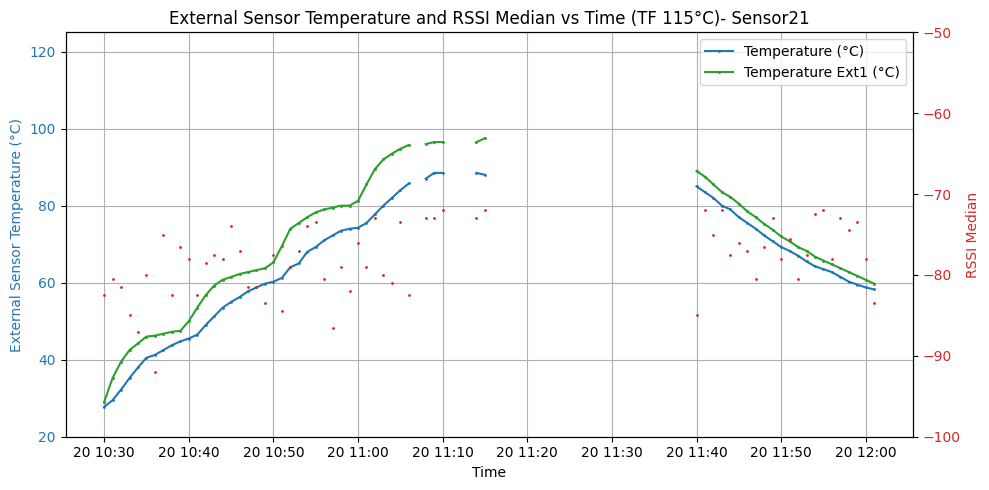

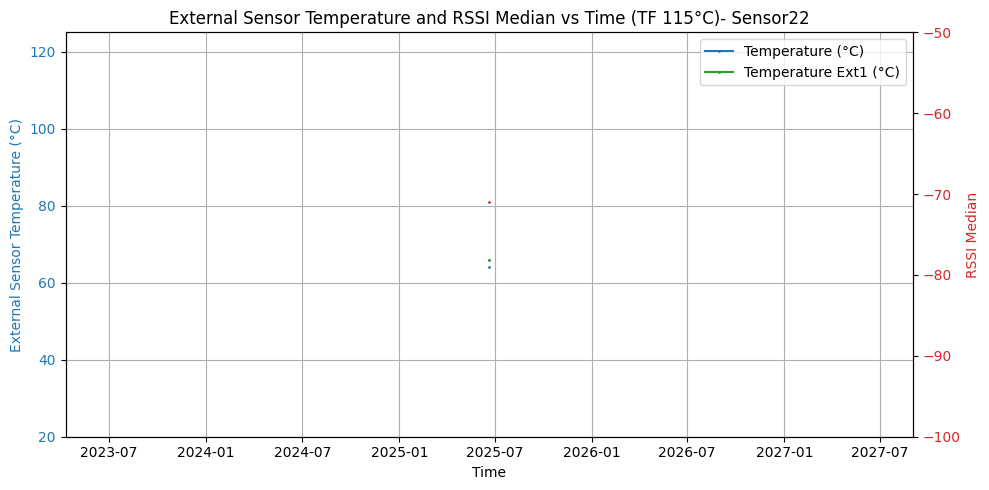

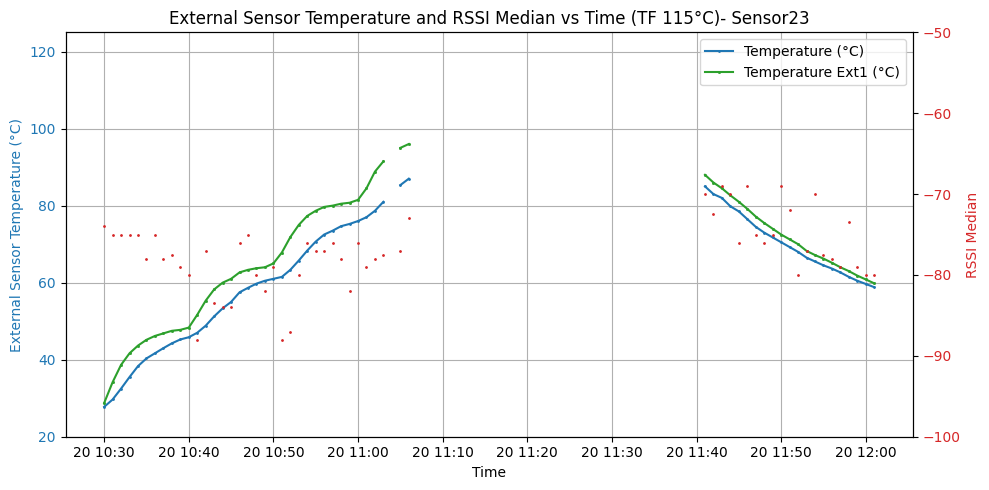

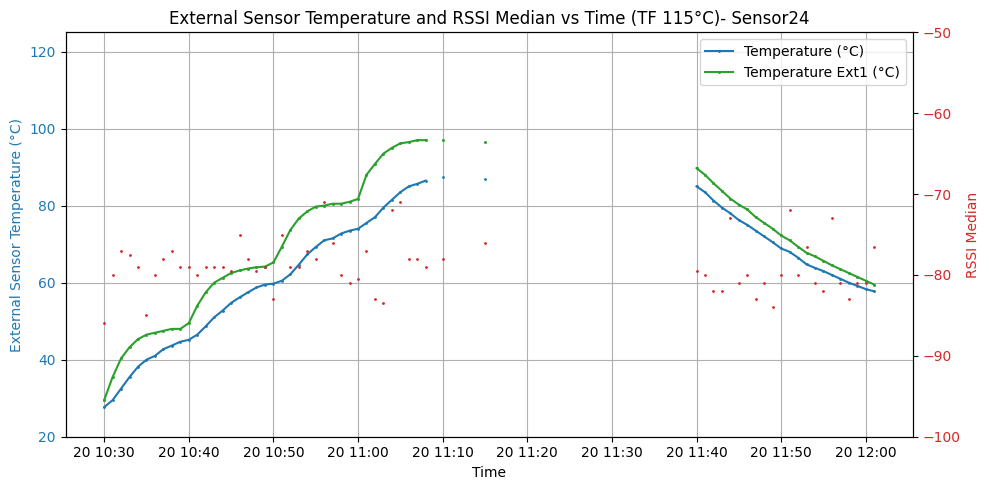

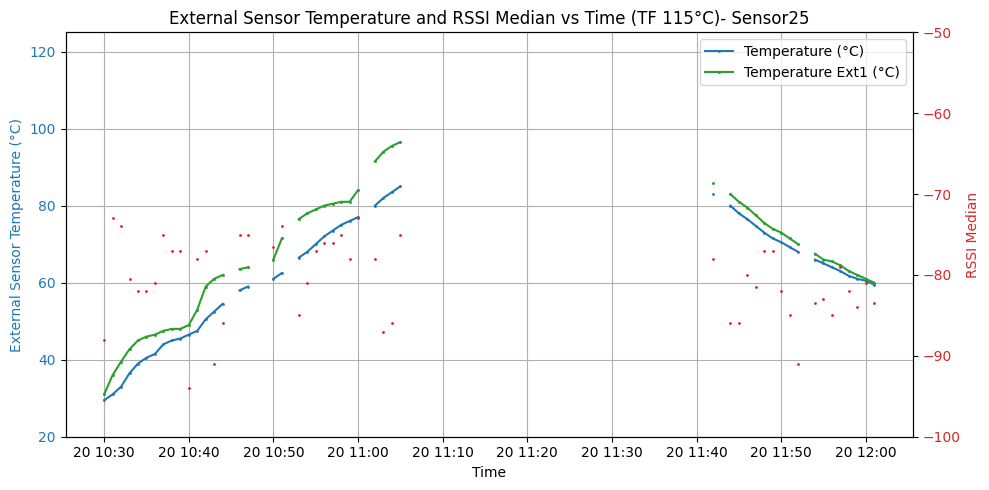

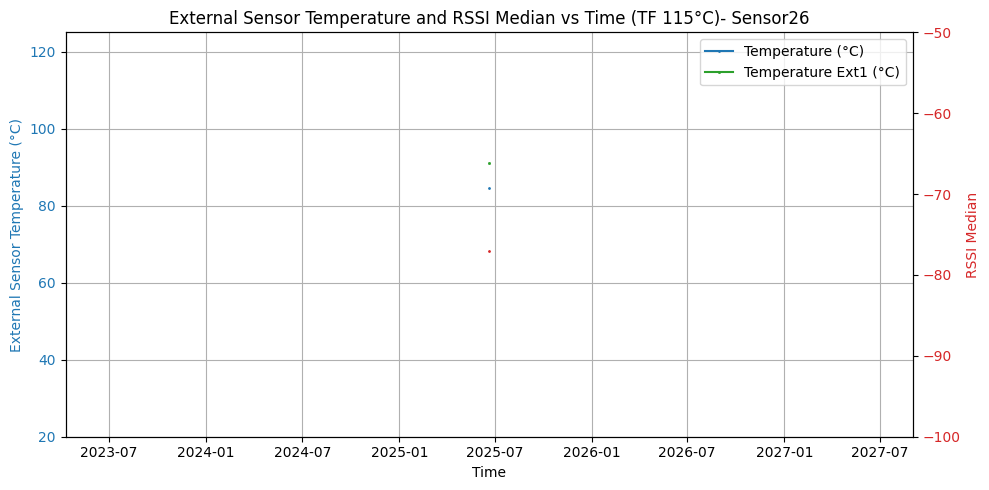

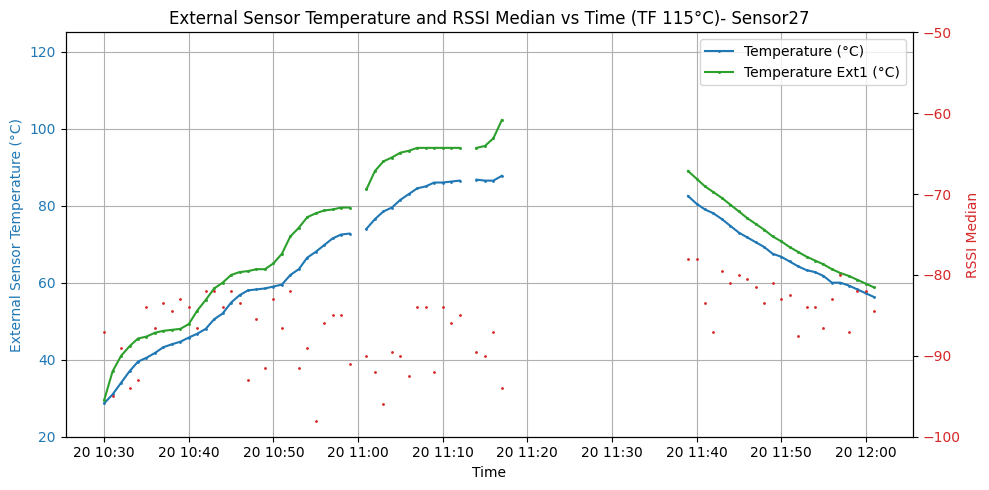

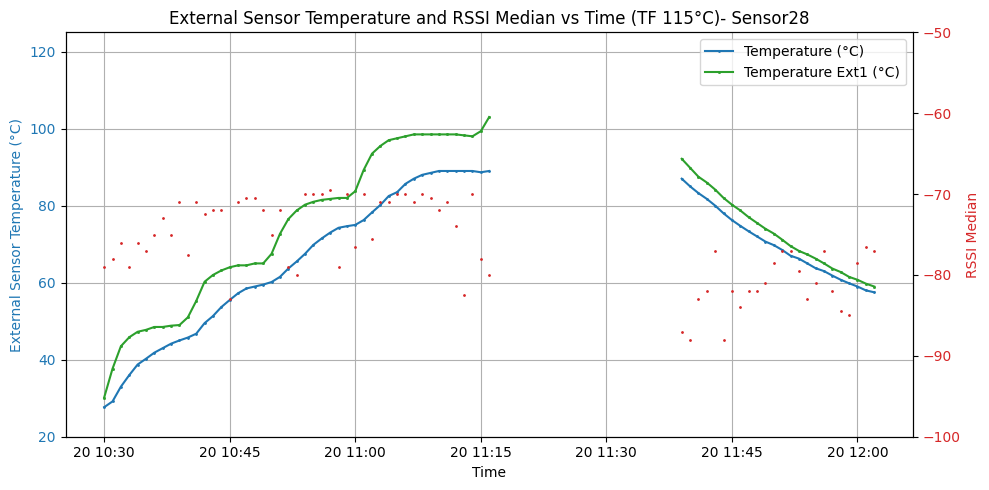

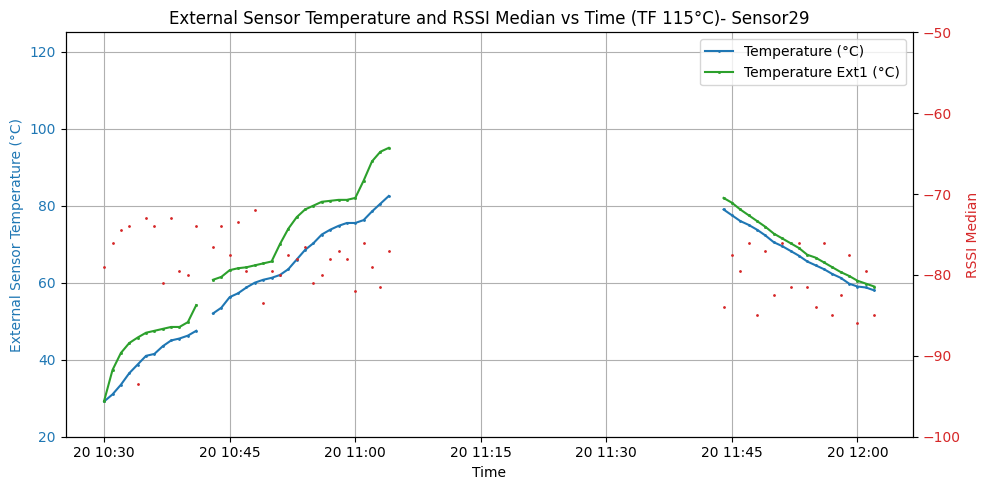

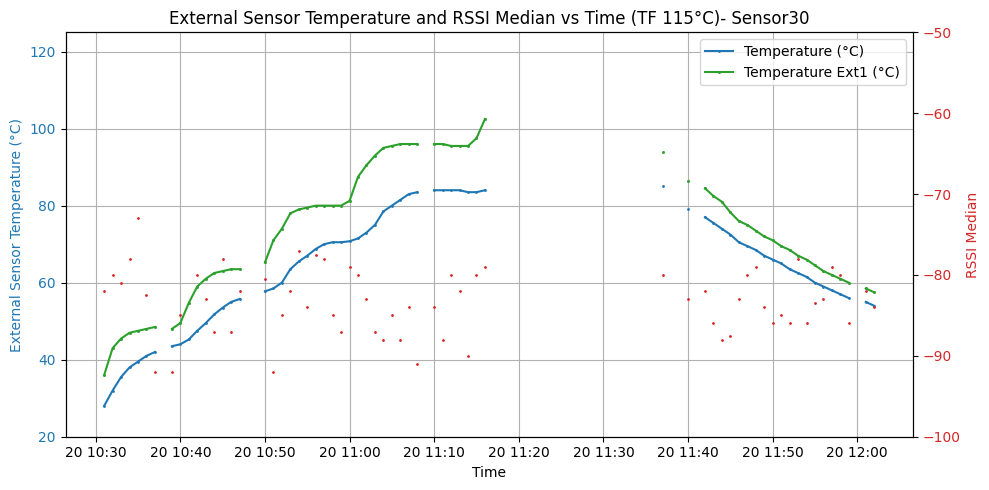

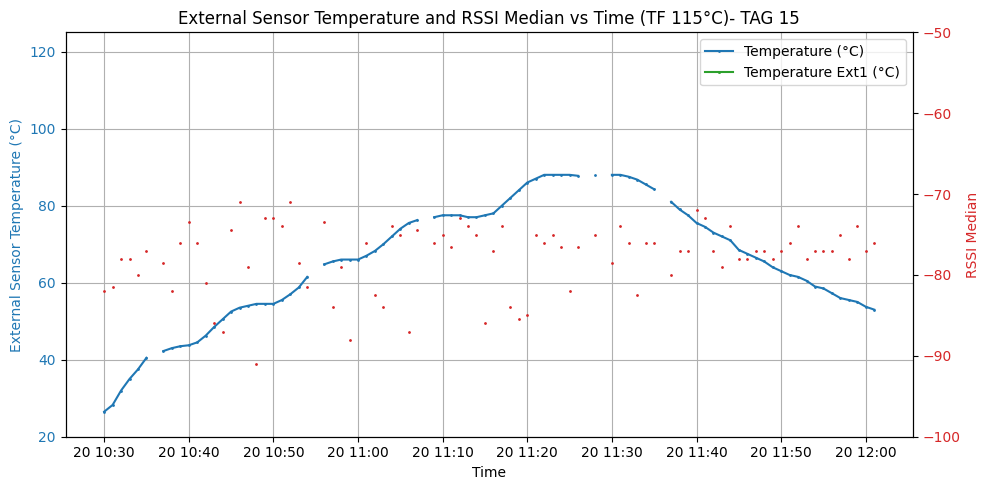

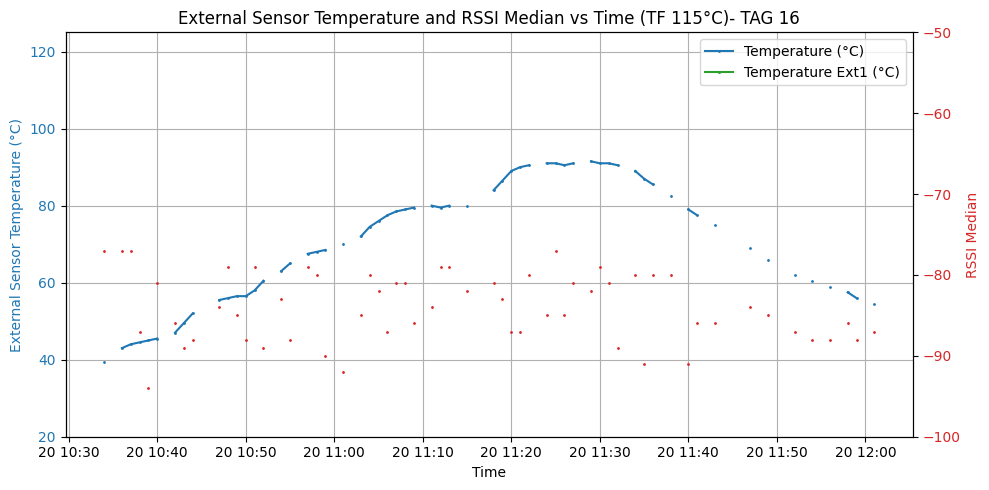

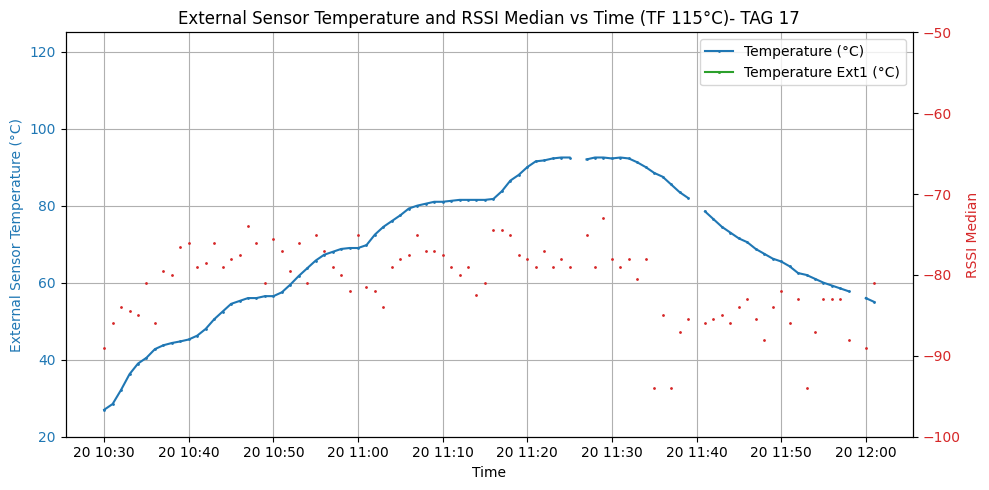

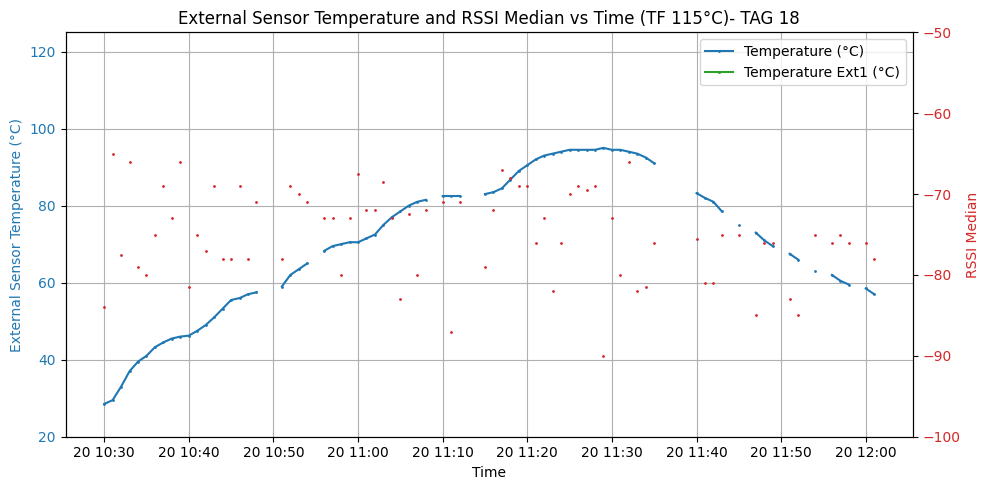

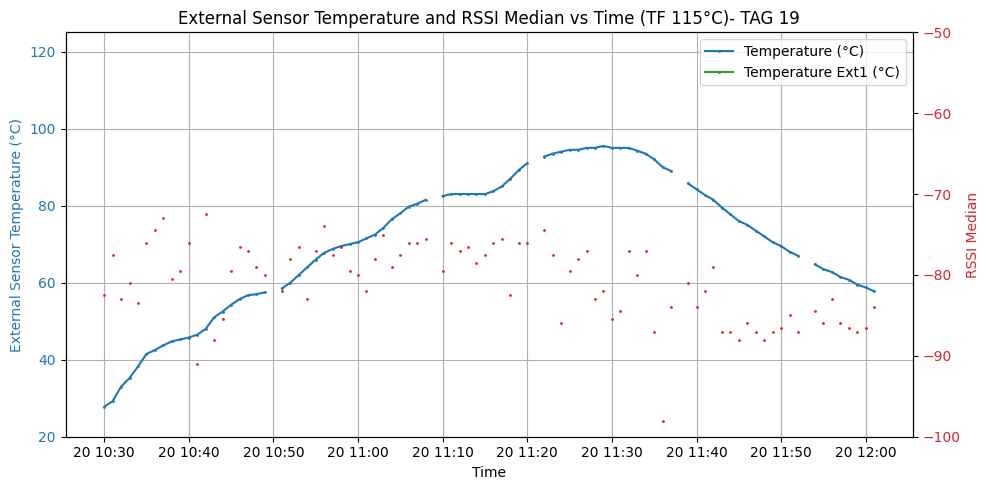

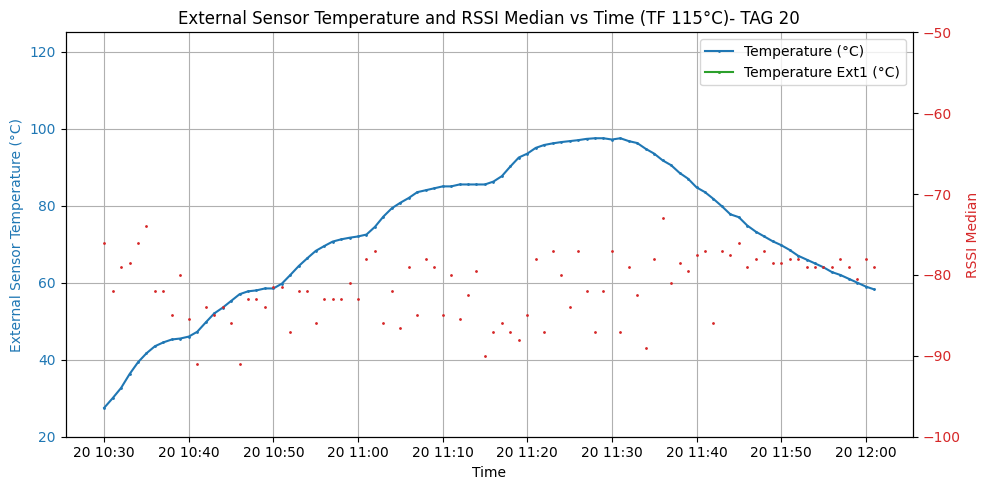

In [16]:
# Usage examples:

# Option 1: Just get the DataFrame (equivalent to the data loading part of your CSV function)
df = get_dataframe_from_database('EDFBeaconCaptures.db', '2025-06-20 10:30:00', '2025-06-20 18:00:00')
print(f"DataFrame shape: {df.shape}")
print(f"Beacons found: {sorted(df['BeaconDescription'].unique())}")
print(f"Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")

# Option 2: Full plotting function (equivalent to your complete CSV function)
plot_temperature_and_rssi_median_vs_time_per_tag_from_db(
    db_path='EDFBeaconCaptures.db',
    startup_datetime_str='2025-06-20 10:30:00',
    cutoff_datetime_str='2025-06-20 18:00:00',
    time_window='1min'
)

In [17]:
# Create a Streamlit web application file
streamlit_app_code = '''
import streamlit as st
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import tempfile
import os

# Page config
st.set_page_config(
    page_title="Beacon Data Analyzer", 
    page_icon="📡", 
    layout="wide"
)

def get_beacons_from_db(db_path):
    """Get list of available beacons from database"""
    try:
        conn = sqlite3.connect(db_path)
        query = "SELECT DISTINCT beacon.Description FROM Beacon beacon ORDER BY beacon.Description"
        beacons = pd.read_sql_query(query, conn)
        conn.close()
        return beacons['Description'].tolist()
    except Exception as e:
        st.error(f"Error reading beacons from database: {e}")
        return []

def get_date_range_from_db(db_path):
    """Get min and max dates from database"""
    try:
        conn = sqlite3.connect(db_path)
        query = "SELECT MIN(DateTime) as min_date, MAX(DateTime) as max_date FROM BeaconEvent"
        result = pd.read_sql_query(query, conn)
        conn.close()
        
        min_date = pd.to_datetime(result['min_date'].iloc[0])
        max_date = pd.to_datetime(result['max_date'].iloc[0])
        return min_date, max_date
    except Exception as e:
        st.error(f"Error reading date range: {e}")
        return None, None

def get_dataframe_from_database(db_path, startup_datetime_str, cutoff_datetime_str, selected_beacons=None):
    """Get DataFrame from database with optional beacon filtering"""
    conn = sqlite3.connect(db_path)
    
    # Build query with optional beacon filtering
    beacon_filter = ""
    params = [startup_datetime_str, cutoff_datetime_str]
    
    if selected_beacons:
        beacon_placeholders = ','.join(['?' for _ in selected_beacons])
        beacon_filter = f"AND beacon.Description IN ({beacon_placeholders})"
        params.extend(selected_beacons)
    
    query = f"""
    SELECT 
        event.DateTime, 
        beacon.Description as BeaconDescription,
        event.ExternalSensorTemperature,
        event.ExternalSensorTemperatureExt1,
        event.RSSI
    FROM BeaconEvent event
    INNER JOIN Beacon beacon ON event.BeaconId = beacon.Id
    WHERE event.DateTime BETWEEN ? AND ? {beacon_filter}
    ORDER BY event.DateTime
    """
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

def create_interactive_plot(df, beacon, time_window):
    """Create interactive Plotly plot for a beacon"""
    beacon_data = df[df['BeaconDescription'] == beacon].copy()
    
    if beacon_data.empty:
        return None
    
    beacon_data.set_index('DateTime', inplace=True)
    
    # Resample data
    temp_resampled = beacon_data['ExternalSensorTemperature'].resample(time_window).mean()
    temp_ext1_resampled = beacon_data['ExternalSensorTemperatureExt1'].resample(time_window).mean()
    rssi_median = beacon_data['RSSI'].resample(time_window).median()
    
    # Create subplot with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add temperature traces
    fig.add_trace(
        go.Scatter(
            x=temp_resampled.index, 
            y=temp_resampled.values,
            mode='lines+markers',
            name='Temperature (°C)',
            line=dict(color='blue'),
            marker=dict(size=4)
        ),
        secondary_y=False,
    )
    
    fig.add_trace(
        go.Scatter(
            x=temp_ext1_resampled.index, 
            y=temp_ext1_resampled.values,
            mode='lines+markers',
            name='Temperature Ext1 (°C)',
            line=dict(color='green'),
            marker=dict(size=4, symbol='square')
        ),
        secondary_y=False,
    )
    
    # Add RSSI trace
    fig.add_trace(
        go.Scatter(
            x=rssi_median.index, 
            y=rssi_median.values,
            mode='markers',
            name='RSSI Median',
            line=dict(color='red'),
            marker=dict(size=4)
        ),
        secondary_y=True,
    )
    
    # Update layout
    fig.update_xaxes(title_text="Time")
    fig.update_yaxis(title_text="Temperature (°C)", range=[20, 125], secondary_y=False)
    fig.update_yaxis(title_text="RSSI (dBm)", range=[-100, -50], secondary_y=True)
    
    fig.update_layout(
        title=f'Temperature and RSSI vs Time - {beacon}',
        hovermode='x unified',
        height=500
    )
    
    return fig

# Main Streamlit app
def main():
    st.title("📡 Beacon Data Analyzer")
    st.markdown("Upload your SQLite database and analyze beacon data interactively!")
    
    # File upload
    uploaded_file = st.file_uploader(
        "Drop your SQLite database file here", 
        type=['db', 'sqlite', 'sqlite3'],
        help="Upload your EDFBeaconCaptures.db file"
    )
    
    if uploaded_file is not None:
        # Save uploaded file temporarily
        with tempfile.NamedTemporaryFile(delete=False, suffix='.db') as tmp_file:
            tmp_file.write(uploaded_file.read())
            db_path = tmp_file.name
        
        try:
            # Get available beacons
            beacons = get_beacons_from_db(db_path)
            
            if not beacons:
                st.error("No beacons found in the database or error reading data.")
                return
            
            # Get date range
            min_date, max_date = get_date_range_from_db(db_path)
            
            if min_date is None or max_date is None:
                st.error("Could not determine date range from database.")
                return
            
            # Sidebar controls
            st.sidebar.header("🎛️ Controls")
            
            # Beacon selection
            selected_beacons = st.sidebar.multiselect(
                "Select Beacon(s)",
                options=beacons,
                default=beacons[:3] if len(beacons) >= 3 else beacons,
                help="Choose one or more beacons to analyze"
            )
            
            # Date range selection
            col1, col2 = st.sidebar.columns(2)
            with col1:
                start_date = st.date_input(
                    "Start Date", 
                    value=min_date.date(),
                    min_value=min_date.date(),
                    max_value=max_date.date()
                )
            with col2:
                end_date = st.date_input(
                    "End Date", 
                    value=max_date.date(),
                    min_value=min_date.date(),
                    max_value=max_date.date()
                )
            
            # Time range selection
            col3, col4 = st.sidebar.columns(2)
            with col3:
                start_time = st.time_input("Start Time", value=datetime.strptime("10:00", "%H:%M").time())
            with col4:
                end_time = st.time_input("End Time", value=datetime.strptime("18:00", "%H:%M").time())
            
            # Time window selection
            time_window = st.sidebar.selectbox(
                "Time Window for Resampling",
                options=['1min', '5min', '10min', '30min', '1H'],
                index=1
            )
            
            # Combine date and time
            start_datetime = datetime.combine(start_date, start_time)
            end_datetime = datetime.combine(end_date, end_time)
            
            # Analysis button
            if st.sidebar.button("🔍 Analyze Data", type="primary"):
                if not selected_beacons:
                    st.warning("Please select at least one beacon.")
                    return
                
                # Get data
                with st.spinner("Loading data from database..."):
                    df = get_dataframe_from_database(
                        db_path, 
                        start_datetime.strftime('%Y-%m-%d %H:%M:%S'),
                        end_datetime.strftime('%Y-%m-%d %H:%M:%S'),
                        selected_beacons
                    )
                
                if df.empty:
                    st.warning("No data found for the selected criteria.")
                    return
                
                # Display summary
                st.success(f"✅ Found {len(df)} data points for {len(selected_beacons)} beacon(s)")
                
                # Show data summary
                with st.expander("📊 Data Summary"):
                    col1, col2, col3 = st.columns(3)
                    with col1:
                        st.metric("Total Records", len(df))
                    with col2:
                        st.metric("Date Range", f"{len(df['DateTime'].dt.date.unique())} days")
                    with col3:
                        st.metric("Beacons", len(df['BeaconDescription'].unique()))
                    
                    st.dataframe(df.head())
                
                # Create plots for each beacon
                st.header("📈 Beacon Analysis")
                
                for beacon in selected_beacons:
                    beacon_df = df[df['BeaconDescription'] == beacon]
                    if not beacon_df.empty:
                        st.subheader(f"🎯 {beacon}")
                        
                        # Create interactive plot
                        fig = create_interactive_plot(df, beacon, time_window)
                        if fig:
                            st.plotly_chart(fig, use_container_width=True)
                        
                        # Show beacon statistics
                        with st.expander(f"Statistics for {beacon}"):
                            col1, col2, col3 = st.columns(3)
                            with col1:
                                st.metric(
                                    "Avg Temperature", 
                                    f"{beacon_df['ExternalSensorTemperature'].mean():.1f}°C"
                                )
                            with col2:
                                st.metric(
                                    "Avg RSSI", 
                                    f"{beacon_df['RSSI'].mean():.1f} dBm"
                                )
                            with col3:
                                st.metric(
                                    "Data Points", 
                                    len(beacon_df)
                                )
        
        finally:
            # Clean up temporary file
            if os.path.exists(db_path):
                os.unlink(db_path)
    
    else:
        st.info("👆 Please upload your SQLite database file to get started!")
        
        # Show example
        st.markdown("### 🔍 What this app does:")
        st.markdown("""
        1. **📁 Upload Database**: Drop your SQLite database file
        2. **🎯 Select Beacons**: Choose which beacons to analyze
        3. **📅 Set Time Range**: Pick date and time filters
        4. **📊 View Results**: Interactive plots and statistics
        5. **🎛️ Adjust Settings**: Change time windows and filters
        """)

if __name__ == "__main__":
    main()
'''

# Save the Streamlit app to a file
with open('beacon_analyzer_app.py', 'w', encoding='utf-8') as f:
    f.write(streamlit_app_code)

print("✅ Streamlit app created as 'beacon_analyzer_app.py'")
print("🚀 To run the app, execute in terminal:")
print("   streamlit run beacon_analyzer_app.py")
print()
print("📋 Features of the app:")
print("   • Drag & drop database upload")
print("   • Multi-beacon selection")
print("   • Date/time range filtering") 
print("   • Interactive Plotly charts")
print("   • Real-time data statistics")
print("   • Responsive web interface")

✅ Streamlit app created as 'beacon_analyzer_app.py'
🚀 To run the app, execute in terminal:
   streamlit run beacon_analyzer_app.py

📋 Features of the app:
   • Drag & drop database upload
   • Multi-beacon selection
   • Date/time range filtering
   • Interactive Plotly charts
   • Real-time data statistics
   • Responsive web interface


# 🚀 How to Run the Beacon Analyzer App

## Step 1: Open Terminal/Command Prompt
Navigate to your project directory:
```bash
cd "c:\Users\adrien.lascar\Documents\GitHub\ICE%20DETECTOR\DATA_ANALYSIS\TestDataBase"
```

## Step 2: Run the Streamlit App
```bash
streamlit run beacon_analyzer_app.py
```

## Step 3: Use the Web Interface
The app will automatically open in your browser at `http://localhost:8501`

## 🎯 App Features:

### 📁 **File Upload**
- Drag and drop your `EDFBeaconCaptures.db` file
- Supports `.db`, `.sqlite`, `.sqlite3` files

### 🎛️ **Interactive Controls**
- **Beacon Selection**: Multi-select dropdown with all available beacons
- **Date Range**: Pick start and end dates from available data
- **Time Range**: Set specific hours (e.g., 10:00 to 18:00)
- **Time Window**: Choose resampling interval (1min, 5min, 10min, 30min, 1H)

### 📊 **Visualizations**
- **Interactive Plotly Charts**: Zoom, pan, hover for details
- **Dual Y-axis**: Temperature on left, RSSI on right
- **Individual Plots**: Separate chart for each selected beacon
- **Real-time Statistics**: Data points, averages, ranges

### 📈 **Data Analysis**
- **Automatic Resampling**: Mean for temperature, median for RSSI
- **Data Filtering**: By beacon, date range, and time window
- **Export Ready**: All charts can be downloaded as images
- **Responsive Design**: Works on desktop and mobile

## 💡 Usage Tips:
- Start with 2-3 beacons to avoid overcrowding
- Use shorter time windows (1min) for detailed analysis
- Use longer time windows (30min, 1H) for trend overview
- Check data summary before plotting for data availability